# **Neural Network Agent Using Epsilon-Greedy Method**

In [ ]:
!pip install gym==0.25.2
# Import necessary libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Define the Q-Network for Deep Q-Learning
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                          # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, action_size) # Second fully connected layer

    def forward(self, state):
        x = self.relu(self.fc1(state))  # Apply ReLU activation on the output of first layer
        return self.fc2(x)              # Return the output of the second layer

# Class for managing the Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)  # Initialize a deque for storing experiences

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # Add experience to memory

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  # Randomly sample a batch of experiences

    def __len__(self):
        return len(self.memory)  # Return the current size of the memory

# Function to train the Q-Network
def train_model(model, memory, optimizer):
    if len(memory) < batch_size:
        return  # Do not train if not enough samples in memory
    batch = memory.sample(batch_size)  # Sample a batch from the memory
    states, actions, rewards, next_states, dones = zip(*batch)

    # Prepare tensors for states, actions, rewards, next_states, and dones
    state_vectors = torch.zeros(len(states), state_size)
    state_vectors[np.arange(len(states)), states] = 1
    next_state_vectors = torch.zeros(len(next_states), state_size)
    next_state_vectors[np.arange(len(next_states)), next_states] = 1

    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Compute the current Q values and the maximum Q values for next states
    current_q = model(state_vectors).gather(1, actions.unsqueeze(1)).squeeze(1)
    max_next_q = model(next_state_vectors).detach().max(1)[0]
    expected_q = rewards + gamma * max_next_q * (1 - dones)

    # Calculate loss, perform backpropagation and update model weights
    loss = nn.MSELoss()(current_q, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Set up the environment
env = gym.make('Taxi-v3')                     # Create Taxi-v3 environment
state_size = env.observation_space.n          # Get size of state space
action_size = env.action_space.n              # Get size of action space

# Define hyperparameters
gamma = 0.99           # Discount factor for future rewards
epsilon = 1.0          # Exploration rate
epsilon_min = 0.01     # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for exploration
learning_rate = 0.001  # Learning rate for optimizer
memory_size = 100000   # Capacity of replay memory
batch_size = 32        # Batch size for training

# Initialize the Q-Network, Replay Memory, and optimizer
model = QNetwork(state_size, action_size)
memory = ReplayMemory(memory_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists for storing total rewards and epsilon values after each episode
total_rewards = []
epsilons = []

# Main training loop
for episode in range(2000):
    state = env.reset()  # Reset the environment
    state_index = state[0] if isinstance(state, tuple) else state  # Get state index
    total_reward = 0  # Initialize total reward for the episode

    while True:
        state_vector = torch.zeros(state_size)  # Initialize state vector
        state_vector[state_index] = 1  # Set current state in state vector

        # Decide action based on epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()  # Choose random action
        else:
            action = model(state_vector).argmax().item()  # Choose action with highest Q-value

        # Take action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)
        next_state_index = next_state[0] if isinstance(next_state, tuple) else next_state

        # Store experience in memory
        memory.add(state_index, action, reward, next_state_index, done)

        state_index = next_state_index  # Update the state index
        total_reward += reward  # Accumulate reward

        # Train the model
        train_model(model, memory, optimizer)

        if done:
            break  # Break the loop if the episode is finished

    # Update total_rewards and epsilons lists after each episode
    total_rewards.append(total_reward)
    epsilons.append(epsilon)

    # Update epsilon using decay
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {epsilon:.2f}")

# Save the trained model
torch.save(model.state_dict(), 'taxi_dqn_model.pth')


Episode: 0, Total reward: -762, Epsilon: 0.99
Episode: 1, Total reward: -615, Epsilon: 0.99
Episode: 2, Total reward: -857, Epsilon: 0.99
Episode: 3, Total reward: -857, Epsilon: 0.98
Episode: 4, Total reward: -731, Epsilon: 0.98
Episode: 5, Total reward: -722, Epsilon: 0.97
Episode: 6, Total reward: -857, Epsilon: 0.97
Episode: 7, Total reward: -623, Epsilon: 0.96
Episode: 8, Total reward: -650, Epsilon: 0.96
Episode: 9, Total reward: -722, Epsilon: 0.95
Episode: 10, Total reward: -618, Epsilon: 0.95
Episode: 11, Total reward: -722, Epsilon: 0.94
Episode: 12, Total reward: -830, Epsilon: 0.94
Episode: 13, Total reward: -731, Epsilon: 0.93
Episode: 14, Total reward: -713, Epsilon: 0.93
Episode: 15, Total reward: -650, Epsilon: 0.92
Episode: 16, Total reward: -740, Epsilon: 0.92
Episode: 17, Total reward: -785, Epsilon: 0.91
Episode: 18, Total reward: -830, Epsilon: 0.91
Episode: 19, Total reward: -722, Epsilon: 0.90
Episode: 20, Total reward: -740, Epsilon: 0.90
Episode: 21, Total rewa

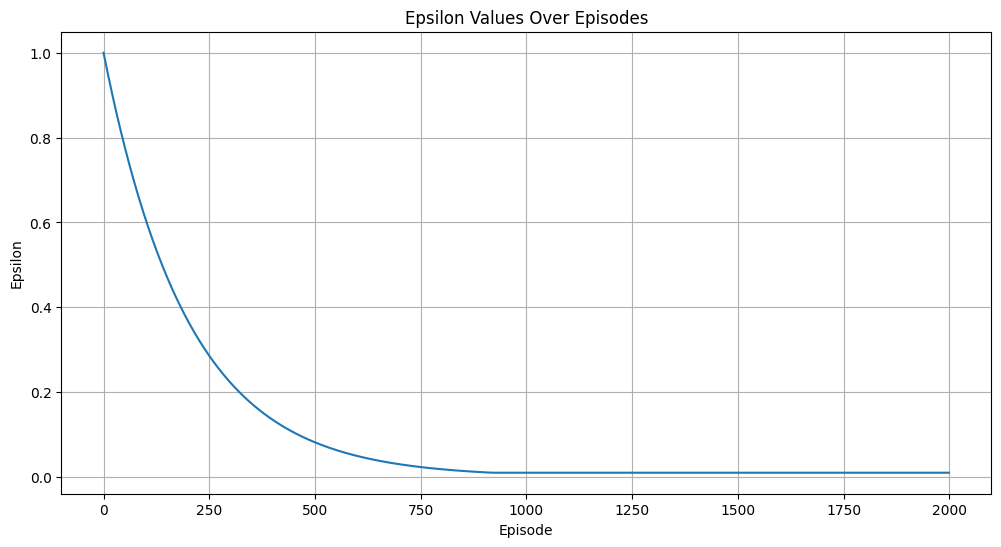

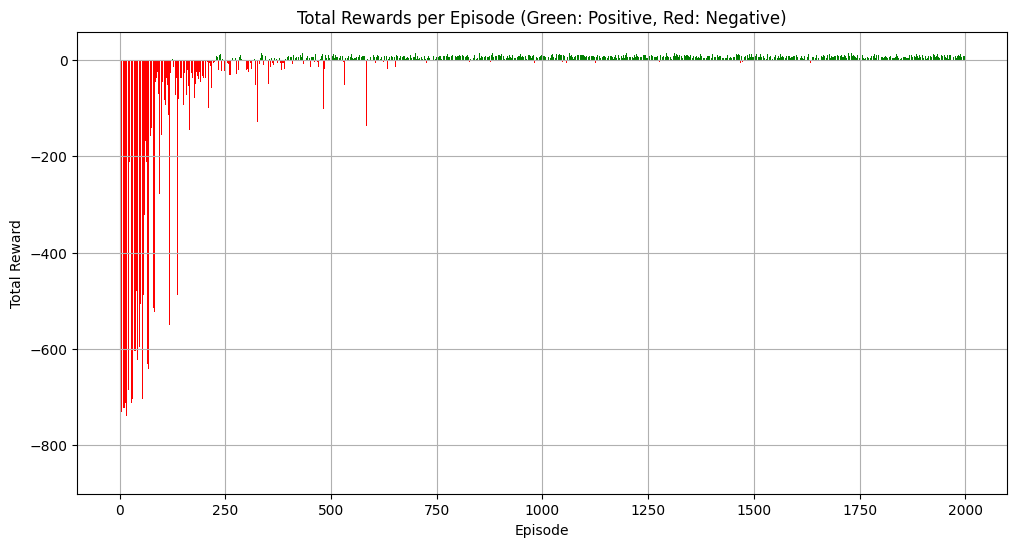

In [ ]:
# Plotting the epsilon values
plt.figure(figsize=(12, 6))
plt.plot(epsilons)
plt.title('Epsilon Values Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)
plt.show()

# Color-coding the bars based on positive or negative rewards
colors = ['green' if reward >= 0 else 'red' for reward in total_rewards]

# Plotting the total rewards with color coding
plt.figure(figsize=(12, 6))
plt.bar(range(len(total_rewards)), total_rewards, color=colors)
plt.title('Total Rewards per Episode (Green: Positive, Red: Negative)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()



# **Epsilon-Greedy Method Experimental Evaluation**

Episode 1/100, Average Reward: 7.80
Episode 2/100, Average Reward: 7.92
Episode 3/100, Average Reward: 8.50
Episode 4/100, Average Reward: 7.72
Episode 5/100, Average Reward: 8.18
Episode 6/100, Average Reward: 7.69
Episode 7/100, Average Reward: 7.84
Episode 8/100, Average Reward: 7.92
Episode 9/100, Average Reward: 8.03
Episode 10/100, Average Reward: 8.43
Episode 11/100, Average Reward: 7.51
Episode 12/100, Average Reward: 7.46
Episode 13/100, Average Reward: 8.05
Episode 14/100, Average Reward: 8.52
Episode 15/100, Average Reward: 7.58
Episode 16/100, Average Reward: 7.20
Episode 17/100, Average Reward: 8.09
Episode 18/100, Average Reward: 8.09
Episode 19/100, Average Reward: 8.04
Episode 20/100, Average Reward: 7.86
Episode 21/100, Average Reward: 7.79
Episode 22/100, Average Reward: 7.63
Episode 23/100, Average Reward: 7.84
Episode 24/100, Average Reward: 7.96
Episode 25/100, Average Reward: 8.05
Episode 26/100, Average Reward: 7.80
Episode 27/100, Average Reward: 7.52
Episode 28

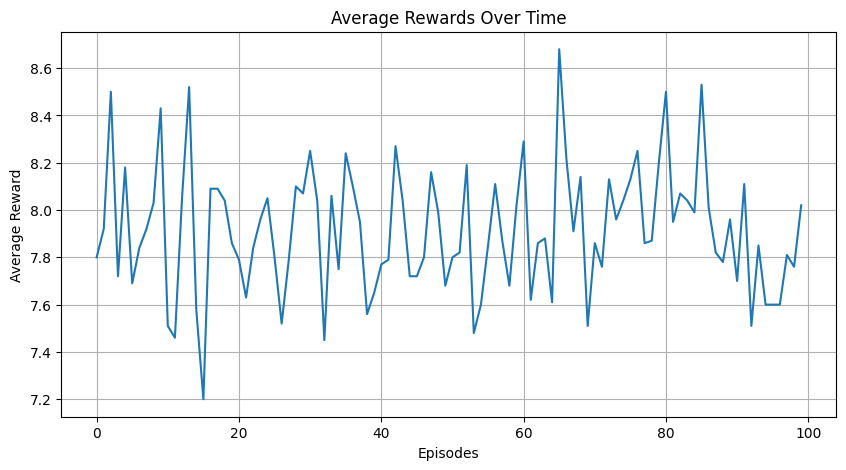

In [ ]:
# Set up the environment
env = gym.make('Taxi-v3')  # Initialize the Taxi-v3 environment from OpenAI Gym
state_size = env.observation_space.n  # Get the size of the state space
action_size = env.action_space.n  # Get the size of the action space

# Function to evaluate the agent's performance over multiple episodes
def evaluate_agent(agent, num_episodes=100):
    episode_rewards = []  # List to store rewards for each episode
    for _ in range(num_episodes):  # Loop over a number of episodes
        state = env.reset()  # Reset the environment to start a new episode
        total_reward = 0  # Initialize total reward for the episode
        while True:
            state_vector = torch.zeros(state_size)  # Create a zero vector for the state
            state_vector[state] = 1  # Set the current state in the state vector

            # Choose the best action for the current state without exploration (exploitation only)
            action = agent(state_vector).argmax().item()

            # Execute the chosen action and observe the reward and next state
            next_state, reward, done, _ = env.step(action)
            total_reward += reward  # Update the total reward

            state = next_state  # Update the state

            if done:
                break  # Break the loop if the episode ends
        episode_rewards.append(total_reward)  # Append the total reward of the episode
    return episode_rewards  # Return the rewards for all episodes

# Load the trained model
model = QNetwork(state_size, action_size)  # Initialize the Q-Network
model.load_state_dict(torch.load('taxi_dqn_model.pth'))  # Load the trained model weights

# Lists to store average rewards
average_rewards = []

# Number of evaluation episodes
num_evaluation_episodes = 100  # Set the number of episodes for evaluation

for episode in range(1, num_evaluation_episodes + 1):
    eval_rewards = evaluate_agent(model)  # Evaluate the agent
    avg_reward = np.mean(eval_rewards)  # Calculate the average reward
    average_rewards.append(avg_reward)  # Append the average reward to the list
    print(f"Episode {episode}/{num_evaluation_episodes}, Average Reward: {avg_reward:.2f}")

# Plotting the results
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(average_rewards)  # Plot the average rewards
plt.title('Average Rewards Over Time')  # Title of the plot
plt.xlabel('Episodes')  # X-axis label
plt.ylabel('Average Reward')  # Y-axis label
plt.grid(True)  # Add a grid to the plot
plt.show()  # Display the plot


# **Softmax Neural Agent**

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
from collections import deque
import random

def softmax(z):
    """Compute softmax values for each sets of scores in z."""
    return torch.exp(z) / torch.sum(torch.exp(z), axis=0)

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes=[128, 64]):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], action_size)

    def forward(self, state):
        x = self.relu1(self.fc1(state))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Function to train the Q-Network
def train_model(model, memory, optimizer, scheduler, batch_size, gamma):
    if len(memory) < batch_size:
        return
    batch = memory.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    state_vectors = torch.FloatTensor(states)
    next_state_vectors = torch.FloatTensor(next_states)
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    current_q = model(state_vectors).gather(1, actions.unsqueeze(1)).squeeze(1)
    max_next_q = model(next_state_vectors).detach().max(1)[0]
    expected_q = rewards + gamma * max_next_q * (1 - dones)

    loss = nn.MSELoss()(current_q, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()  # Adjust the learning rate based on the scheduler


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Define the softmax function
def softmax(z, temperature=1.0):
    """Compute softmax values for each sets of scores in z."""
    return torch.exp(z / temperature) / torch.sum(torch.exp(z / temperature), axis=0)


# Function to select action using Softmax with a decaying temperature
def select_action_softmax(state_vector, temperature):
    with torch.no_grad():
        q_values = model(torch.FloatTensor(state_vector))
        softmax_probs = softmax(q_values, temperature).numpy()
        return np.random.choice(np.arange(action_size), p=softmax_probs)

# Set up the environment
env = gym.make('Taxi-v3')
state_size = env.observation_space.n
action_size = env.action_space.n

# Hyperparameters
gamma = 0.99
initial_learning_rate = 0.001
memory_size = 100000
initial_temperature = 1.0  # Initial softmax temperature
temperature_decay = 0.99  # Decay rate for temperature
min_temperature = 0.01  # Minimum temperature for exploration
batch_size = 64  #  batch size

# Initialize the Q-Network, Replay Memory, and optimizer
model = QNetwork(state_size, action_size)
memory = ReplayMemory(memory_size)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# Main Training Loop
for episode in range(10000):
    state = env.reset()
    total_reward = 0
    temperature = max(min_temperature, initial_temperature * (temperature_decay ** episode))

    while True:
        state_vector = np.zeros(state_size)
        state_vector[state] = 1  # One-hot encoding of state

        action = select_action_softmax(state_vector, temperature)

        next_state, reward, done, _ = env.step(action)
        memory.add(state_vector, action, reward, np.zeros(state_size), done)
        train_model(model, memory, optimizer, scheduler, batch_size, gamma)

        total_reward += reward  # You might want to normalize this

        if done:
            break
    print(f"Episode: {episode}, Total reward: {total_reward}, Temperature: {temperature:.2f}")

# Save the trained model
torch.save(model.state_dict(), 'taxi_dqn_softmax_model.pth')

# **SoftMax Method Experimental Evaluation**

In [ ]:
# Set up the environment
env = gym.make('Taxi-v3')  # Initialize the Taxi-v3 environment from OpenAI Gym
state_size = env.observation_space.n  # Get the size of the state space
action_size = env.action_space.n  # Get the size of the action space

# Function to evaluate the agent's performance over multiple episodes
def evaluate_agent(agent, num_episodes=100):
    episode_rewards = []  # List to store rewards for each episode
    for _ in range(num_episodes):  # Loop over a number of episodes
        state = env.reset()  # Reset the environment to start a new episode
        total_reward = 0  # Initialize total reward for the episode
        while True:
            state_vector = torch.zeros(state_size)  # Create a zero vector for the state
            state_vector[state] = 1  # Set the current state in the state vector

            # Choose the best action for the current state without exploration (exploitation only)
            action = agent(state_vector).argmax().item()

            # Execute the chosen action and observe the reward and next state
            next_state, reward, done, _ = env.step(action)
            total_reward += reward  # Update the total reward

            state = next_state  # Update the state

            if done:
                break  # Break the loop if the episode ends
        episode_rewards.append(total_reward)  # Append the total reward of the episode
    return episode_rewards  # Return the rewards for all episodes

# Load the trained model
model = QNetwork(state_size, action_size)  # Initialize the Q-Network
model.load_state_dict(torch.load('taxi_dqn_softmax_model.pth'))  # Load the trained model weights

# Lists to store average rewards
average_rewards = []

# Number of evaluation episodes
num_evaluation_episodes = 100  # Set the number of episodes for evaluation

for episode in range(1, num_evaluation_episodes + 1):
    eval_rewards = evaluate_agent(model)  # Evaluate the agent
    avg_reward = np.mean(eval_rewards)  # Calculate the average reward
    average_rewards.append(avg_reward)  # Append the average reward to the list
    print(f"Episode {episode}/{num_evaluation_episodes}, Average Reward: {avg_reward:.2f}")

# Plotting the results
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(average_rewards)  # Plot the average rewards
plt.title('Average Rewards Over Time')  # Title of the plot
plt.xlabel('Episodes')  # X-axis label
plt.ylabel('Average Reward')  # Y-axis label
plt.grid(True)  # Add a grid to the plot
plt.show()  # Display the plot
